<a href="https://colab.research.google.com/github/kishansheth/interfaces-hw1/blob/master/Interfaces_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Combination Lock - Visual Interfaces HW1
Kishan Sheth (kps2138)

Professor John Kender



##1.1 Domain Engineering Step

For this project, my domain includes my Nikon D5300 DSLR (mounted on a tripod), a black sheet as a backdrop, and my own hand as the subject.

**Camera & Backdrop**

To set up the domain, first, I hung the black sheet from the bunk beds near my desk. Next, I mounted my camera on my tripod and placed this apparatus on my desk. Finally, I marked the location of the tripod on my desk to ensure I take pictures at a consistent distance from the backdrop. 

**Lighting**

To ensure that lighting is consistent, I decided to only use the overhead light in my dorm room and to close the blinds so minimal light could enter through the window. I also kept my camera settings consistent for all images I captured.

**Tools and Environment**

For both the narrative and coding portion of this project, I decided to use a Jupyter Notebook format, hosted on Google Colab. I use OpenCV in Python because I am most familiar with Python for computer vision work. Google Colab is advantageous because it allows me to combine text and code seamlessly. It also comes preloaded with OpenCV, NumPy, and several other useful packages for computer vision tasks.

In [0]:
# Import OpenCV, NumPy, and image viewers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [136]:
# Connect Google Colab to Google Drive to allow file access
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Interfaces/HW1/images/main

main_seq = ['0_c_f.JPG', '0_br_s.JPG', '1_c_f.JPG', '1_tr_s.JPG', '2_c_f.JPG', '2_tl_s.JPG', '3_c_f.JPG', '3_bl_s.JPG', '4_c_f.JPG', '4_tr_s.JPG', '5_c_f.JPG', '5_tl_s.JPG', '6_c_f.JPG', '6_bl_s.JPG', '7_c_f.JPG', '7_br_s.JPG', '8_c_f.JPG', '8_br_s.JPG', '9_c_f.JPG', '9_bl_s.JPG', '10_c_x.JPG', '10_tr_s.JPG', '11_c_f.JPG', '11_br_x.JPG']
friend_seq = ['0_c_f.JPG', '0_tr_s.JPG', '1_c_f.JPG', '1_tl_s.JPG', '2_c_f.JPG', '2_br_s.JPG', '3_c_f.JPG', '3_tl_s.JPG', '4_c_f.JPG', '4_br_s.JPG', '5_c_f.JPG', '5_bl_s.JPG', '6_c_f.JPG', '6_tr_s.JPG', '7_c_f.JPG', '7_br_s.JPG', '8_c_f.JPG', '8_tr_s.JPG', '9_c_f.JPG', '9_tr_s.JPG', '10_c_x.JPG', '10_tr_s.JPG', '11_c_f.JPG', '11_tl_f.JPG']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Interfaces/HW1/images/main


**Image Preprocessing**

My DSLR is set to shoot RGB images with dimensions 4496 x 3000 x 3, which is a little large for quick image processing (approximately 6MB per image). Thus, before processing, I resize each image by a factor of 1/8 using OpenCV's `resize()` function, yielding final images of dimensions 562 x 375 x 3 (approximately 49KB per image). 

In [0]:
# Input: image
# Returns: downscaled and denoised image
def preprocess(im):

  # scale image by factor of 1/8
  im = cv2.resize(im, (int(im.shape[1]/8), int(im.shape[0]/8)))

  # blur to reduce noise
  im = cv2.blur(im, (3,3))

  return im

##1.2 Data Reduction Step

In this step, I use various methods from the OpenCV package to determine what portions of the image are skin versus backdrop. 

**Detecting Skin**

As Professor Kender has mentioned in class, skin is fundamentally the color of blood. Therefore, using a custom `binary_skin_mask()` function, we can create a mask over pixels that are within the range of the color of blood. [Research done by Kolkur et al.](https://arxiv.org/pdf/1708.02694.pdf) suggests that the color range of human skin can be roughly defined as follows:

0.0 <= H <= 50.0 and 0.23 <= S <= 0.68 

and R > 95 and G > 40 and B > 20 

and R > G and R > B

and | R - G | > 15 and A > 15

Although this is what the paper recommends, after some experimentation, I realized this color range doesn't account for some of the darker, or shadowed portions of the hand, given the lighting and subject (me) in my domain.

Therefore, I adjusted the parameters to account for my own domain. I reduced the R threshold to be R > 65 instead of R > 95.



In [0]:
# Turns image from RGB to Binary, separating skin from dark backdrop
# Input: RGB image
# Returns: Binary image - skin is white, backdrop is black
def binary_skin_mask(im):

  # set all pixels with color of skin to white
  for i in range(im.shape[0]):
    for j in range(im.shape[1]):
      pix = im[i][j]
      
      # reverse order because file is in BGR format
      r = pix[2]
      g = pix[1]
      b = pix[0]

      # set skin-colored pixels to white, using Kolkur et al.'s thresholds
      if r>60 and g>40 and b>20 and r>g and r>b:
        im[i][j] = np.array([255, 255, 255])

  # add border to image (helpful for contouring)
  im = cv2.copyMakeBorder(im, top=10, bottom=10, left=10, right=10, borderType= cv2.BORDER_CONSTANT, value=[0,0,0] ) 

  # convert to binary image, using 127 as B/W threshold
  ret, im = cv2.threshold(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY),127,255,0)

  return im

**Image Annotations**

Instead of annotating each image on the image itself, the filename of the image encodes the annotations of the image. For instance, a file that has the title '1_tl_s.jpg' is part of the second sequence (indexing starts at 0), has the target location of 'tl', or top left, and the target position of 's', or 'splayed'. 

For the viewer's sake, I also list these target labels before printing each image.

##1.3 Parsing and Performance Step

In this step I define a grammar and analyze the performance of my system on 12 different sequences of images. 

**Defining a Grammar**

The grammar I choose to define in this step includes 5 different hand locations:

*   center (c)
 *  hand's center of mass is no more than 0.25*image_height pixels away from image center

OTHERWISE

*   top-left (tl)
 *  hand's center of mass is to left and above image center 
*   top-right (tr)
 *  hand's center of mass is to right and above image center 
*   bottom-left (bl)
 *  hand's center of mass is to left and below image center
*   bottom-right (br)
 *  hand's center of mass is to right and below image center

<img src="https://i.imgur.com/yPeRBw7.jpg" alt="Drawing" width=562/>

and 2 different hand positions:

*   fist (f)
 *  perimeter of hand's contour is < 600 pixels
 *  <img src="https://i.imgur.com/e2mKcQu.jpg" alt="Fist" width=300/>

*   splay (s)
 *  perimeter of hand's contour is >= 600 pixels
 *  <img src="https://i.imgur.com/F3y3Yjj.jpg" alt="Splay" width=300/>





**Contour Detection**

Once a binary image has been created, we can use the `findContours()` function in OpenCV to find an approximate border of the hand. I use documentation from [Contours in OpenCV](https://docs.opencv.org/trunk/d3/d05/tutorial_py_table_of_contents_contours.html) for reference. In the images, the largest detected contour is displayed with a green outline.

**Contour Perimeter** (appears in `analyze_sequence()` function)

I find the contour perimeter of the most significant contour using OpenCV's `arcLength()` function.

**Contour Center of Mass** (appears in `analyze_sequence()` function)

I find the contour's approximate center by first, finding a minimum enclosing circle of the contour using OpenCV's `minEnclosingCircle()` function. I treat the center of this minimum enclosing circle as the approximate center of the hand, labelled with a green dot. The actual center of the picture is marked with a red dot. 


In [0]:
# Finds the main contour in an image, discarding negligible ones
# Input: Binary image
# Returns: Main contour of image
def find_contour(im):

  contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # find contour with the most points, ignoring small gaps and noise
  main_len = 0
  main_contour = []

  for contour in contours:
    if len(contour) > main_len:
      main_len = len(contour)
      main_contour = contour

  return main_contour

In [0]:
def predict(im_shape, cen, per):

  # prediction[0] = predicted location, prediction[1] = predicted hand position
  prediction = ['?', '?']

  # center is defined as no more than 0.25*Height pixels away from center
  center_threshold = 0.25*im_shape[0]

  # splayed if perimeter >= 1000, fist if < 1000
  perimeter_threshold = 600

  x_center = im_shape[1]/2
  y_center = im_shape[0]/2

  x_pos = cen[0]
  y_pos = cen[1]

  # predict c, tl, tr, bl, br based on center
  actual_center = np.array((x_center, y_center))
  hand_center = np.array((x_pos, y_pos))

  # find distance from hand center to actual center
  dist = np.linalg.norm(actual_center-hand_center)

  if dist < center_threshold:
    prediction[0] = 'c'
  elif x_pos < x_center and y_pos < y_center:
    prediction[0] = 'tl'
  elif x_pos > x_center and y_pos < y_center:
    prediction[0] = 'tr'
  elif x_pos < x_center and y_pos > y_center:
    prediction[0] = 'bl'
  else:
    prediction[0] = 'br'

  # predict fist or splayed based on perimeter
  if per < perimeter_threshold:
    prediction[1] = 'f'
  else:
    prediction[1] = 's'

  return prediction

SEQUENCE:  0
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


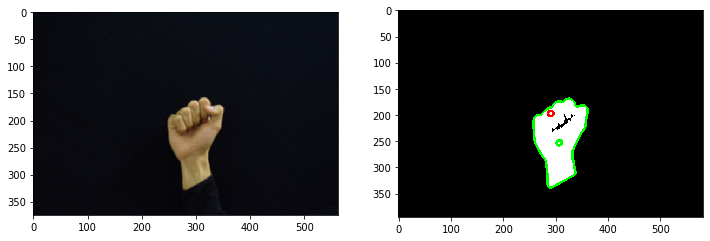

SEQUENCE:  0
Actual:  ['br', 's']
Predicted:  ['br', 's']
CORRECT


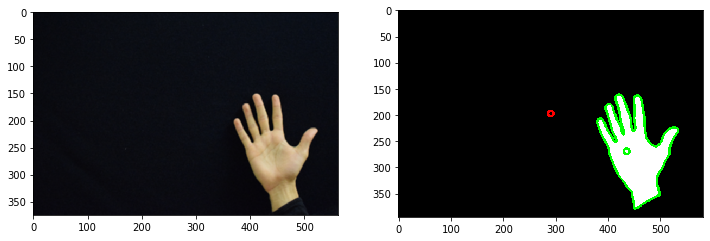

SEQUENCE:  1
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


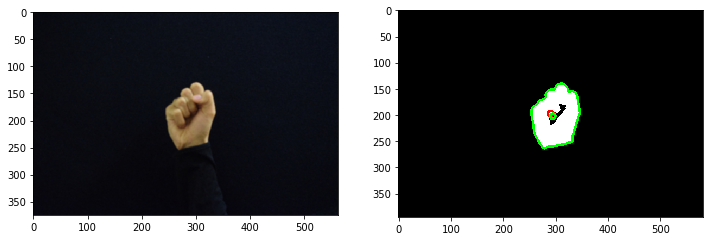

SEQUENCE:  1
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


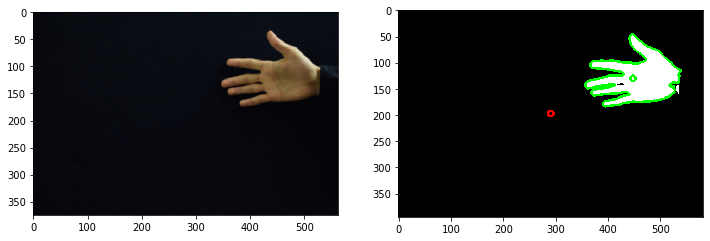

SEQUENCE:  2
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


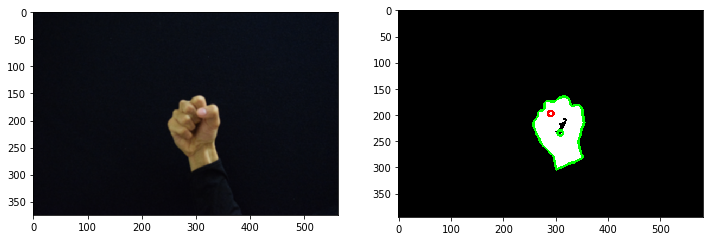

SEQUENCE:  2
Actual:  ['tl', 's']
Predicted:  ['tl', 's']
CORRECT


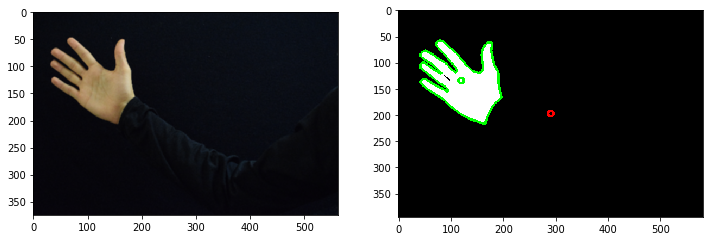

SEQUENCE:  3
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


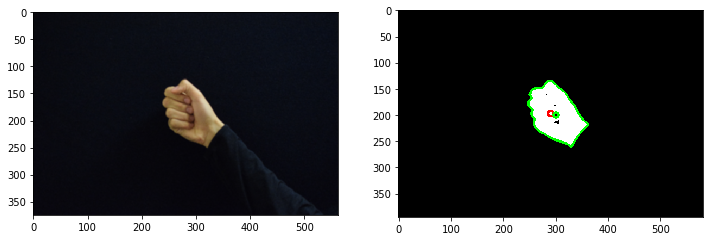

SEQUENCE:  3
Actual:  ['bl', 's']
Predicted:  ['bl', 's']
CORRECT


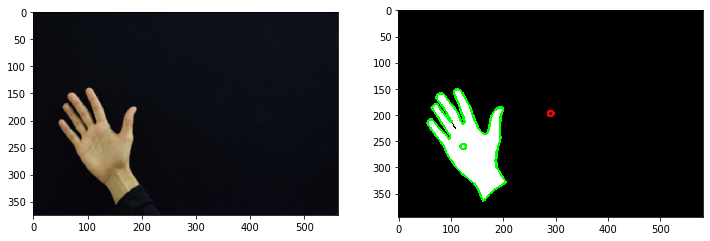

SEQUENCE:  4
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


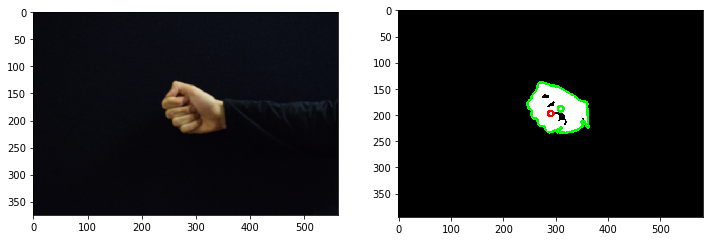

SEQUENCE:  4
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


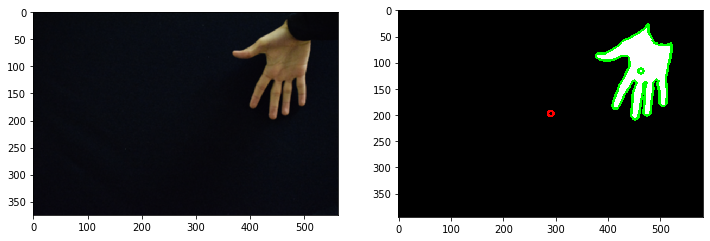

SEQUENCE:  5
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


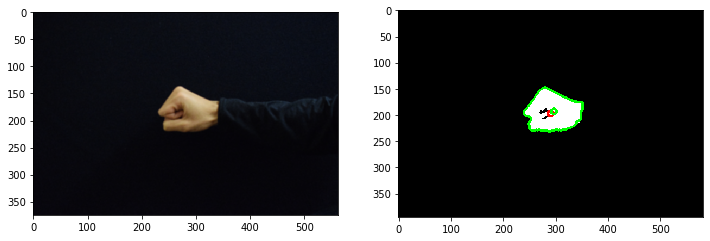

SEQUENCE:  5
Actual:  ['tl', 's']
Predicted:  ['tl', 's']
CORRECT


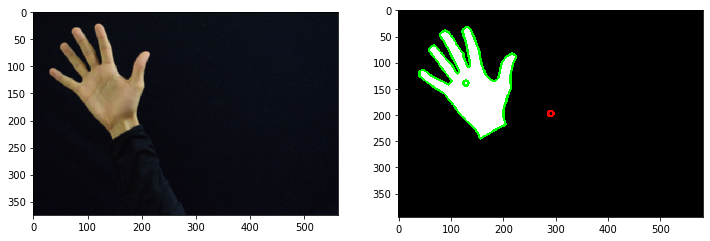

SEQUENCE:  6
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


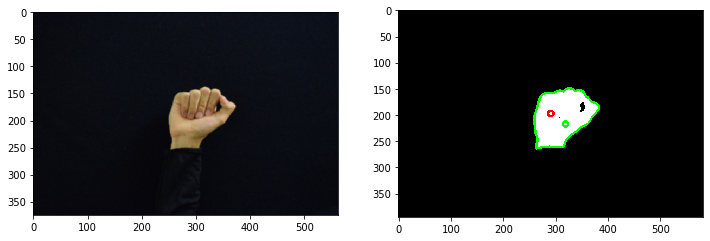

SEQUENCE:  6
Actual:  ['bl', 's']
Predicted:  ['bl', 's']
CORRECT


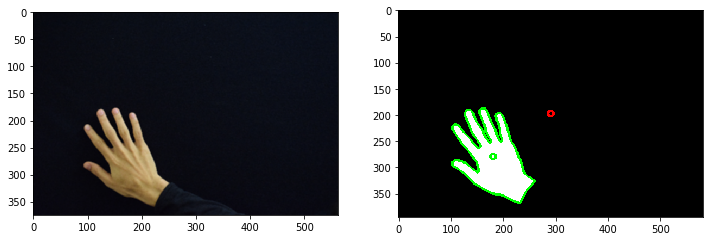

SEQUENCE:  7
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


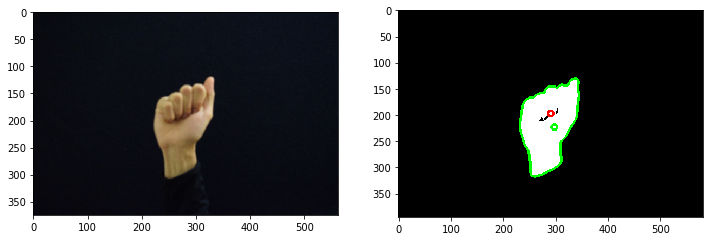

SEQUENCE:  7
Actual:  ['br', 's']
Predicted:  ['br', 's']
CORRECT


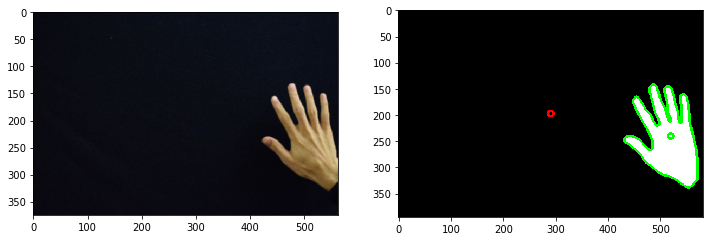

SEQUENCE:  8
Actual:  ['c', 'f']
Predicted:  ['c', 's']
INCORRECT


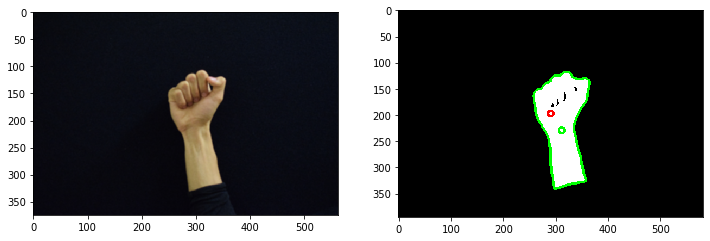

SEQUENCE:  8
Actual:  ['br', 's']
Predicted:  ['br', 's']
CORRECT


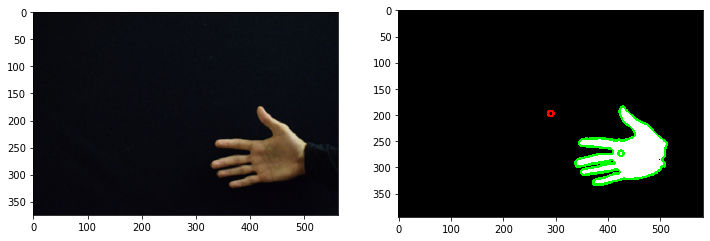

SEQUENCE:  9
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


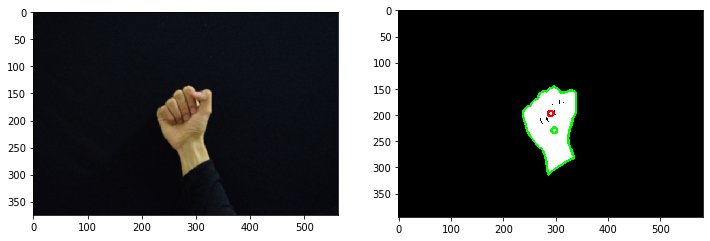

SEQUENCE:  9
Actual:  ['bl', 's']
Predicted:  ['bl', 'f']
INCORRECT


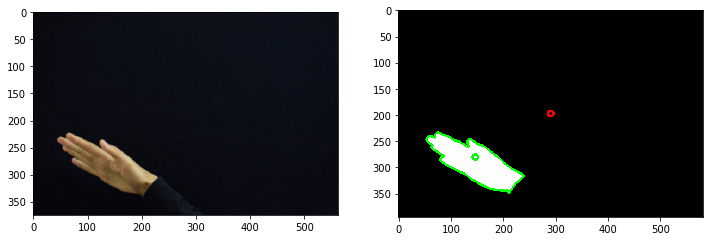

SEQUENCE:  10
Actual:  ['c', 'x']
Predicted:  ['c', 'f']
INCORRECT


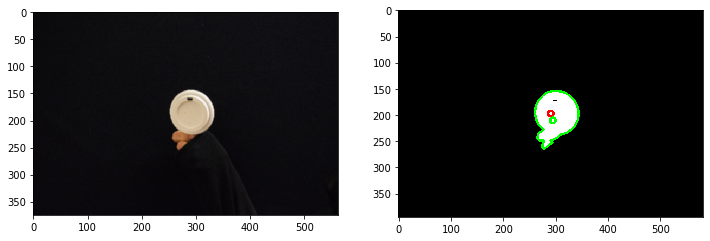

SEQUENCE:  10
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


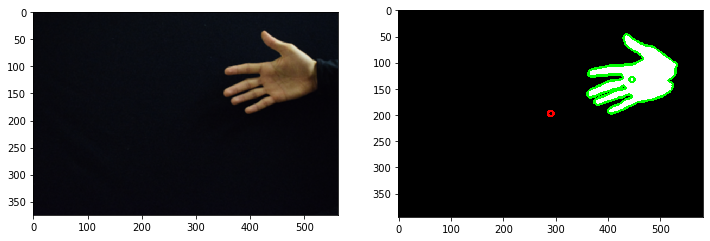

SEQUENCE:  11
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


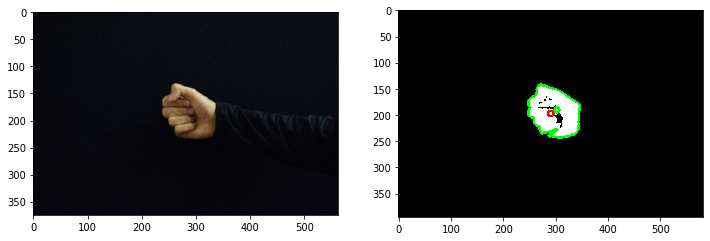

SEQUENCE:  11
Actual:  ['br', 'x']
Predicted:  ['br', 's']
INCORRECT


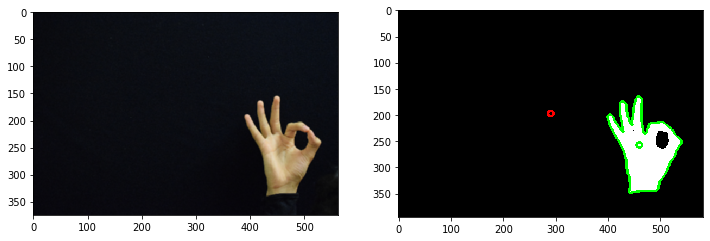

In [141]:
# Input: sequence of image filenames
# Returns: a list of (location, position) tuples of detected hands 
def analyze_sequence(seq):
  predictions = []

  for img_name in seq:

    # split filename to extract target info
    label_split = img_name[:-4].split('_')
    print("SEQUENCE: ", label_split[0])

    # read image from Drive
    orig_img = cv2.imread(img_name)
    processed_img = preprocess(orig_img)
    img = binary_skin_mask(processed_img.copy())

    # find main contour
    main_contour = find_contour(img)
    perimeter = cv2.arcLength(main_contour,True)  # get contour perimeter
    center, radius = cv2.minEnclosingCircle(main_contour) # get contour center

    # convert back to RGB in order to add perimeter and center mark
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # draw perimeter and center mark
    cv2.drawContours(img, [main_contour], 0, (0,255,0), 3)

    cv2.circle(img, (int(img.shape[1]/2), int(img.shape[0]/2)), 5, (255,0,0), 3)
    cv2.circle(img, (int(center[0]), int(center[1])), 5, (0,255,0), 3)

    # use center and perimeter to predict symbol
    prediction = predict(img.shape, center, perimeter)
    predictions.append(prediction)

    # display target label
    target = label_split[1:]
    print("Actual: ", target)
    print("Predicted: ", prediction)

    # see if target and predicted are same
    if set(target) == set(prediction):
      print("CORRECT")
    else:
      print("INCORRECT")

    # display image
    plt.rcParams["figure.figsize"] = (12,6)

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    axarr[1].imshow(img)
    # plt.imshow(img)
    plt.show()
  
  return predictions

pred = analyze_sequence(main_seq)

**Analysis**

After running this system on 12 sequences of images (each of length 2), we can see that the system made an accurate prediction for sequences 0-7, but incorrectly predicted 8-11. 

For sequences 8 and 9, the results were false negatives, while for 10 and 11, they were false positives. 

*False Negatives*

Looking closely at the figure in 8, we can see that my sleeve is not rolled up to my wrist, as it is in most of the other photos. This results in more exposed skin area, increasing the perimeter of the detected contour to above the threshold for a fist. Thus, a splay was falsely detected.

In sequence 9, the second hand position in my sequence, the splay, is tilted in such a way that the gaps between my fingers aren't detected. Thus, the perimeter of my splayed hand appears to be as small as that of my fist. This is an example of losing information from a 3D world in a 2D representation.

*False Positives*

In the first photo of sequence 10, I am not even making a fist. Rather, I am holding a small coffee lid. The coffee lid has a glow similar to that of very light skin, so the system recognizes it as such. The coffee lid's perimeter also roughly equals that of a fist, so the system falsely identifies a fist, even though there is not one present.

In the second photo of sequence 11, I make an "ok" symbol with my hand, instead of an open palm. The system registers this as a splayed hand because the perimeter is still larger than the fist threshold. This is another example of a false positive. 



/content/drive/My Drive/Interfaces/HW1/images/friend
SEQUENCE:  0
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


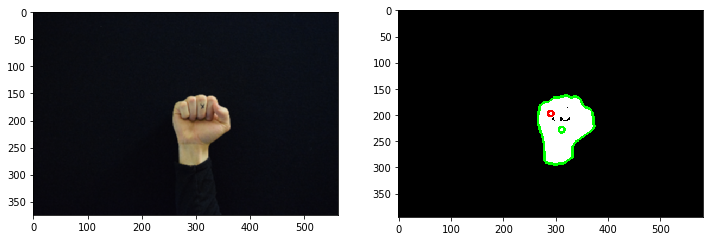

SEQUENCE:  0
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


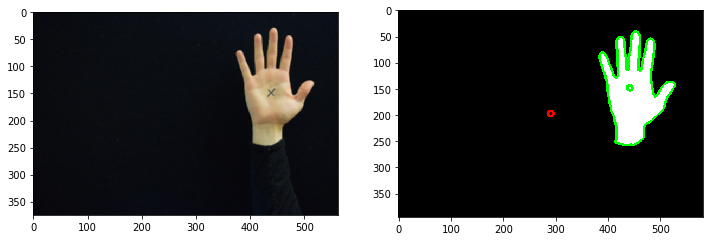

SEQUENCE:  1
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


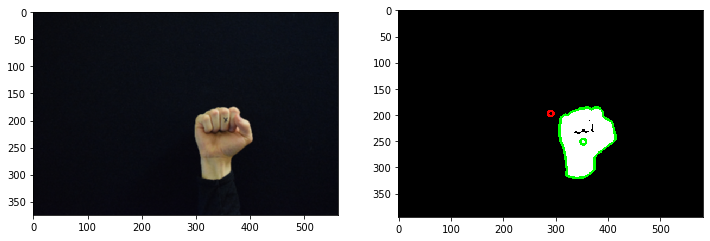

SEQUENCE:  1
Actual:  ['tl', 's']
Predicted:  ['tl', 's']
CORRECT


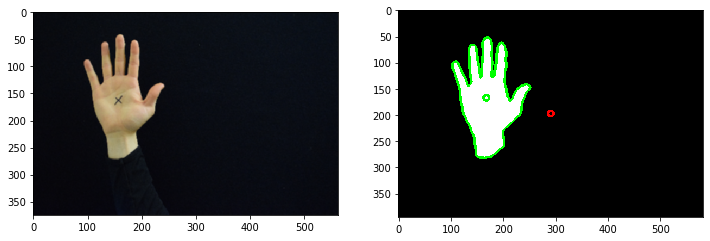

SEQUENCE:  2
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


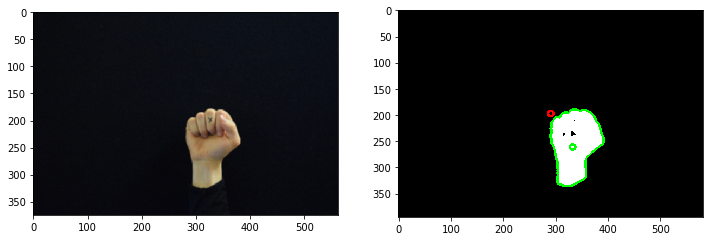

SEQUENCE:  2
Actual:  ['br', 's']
Predicted:  ['br', 's']
CORRECT


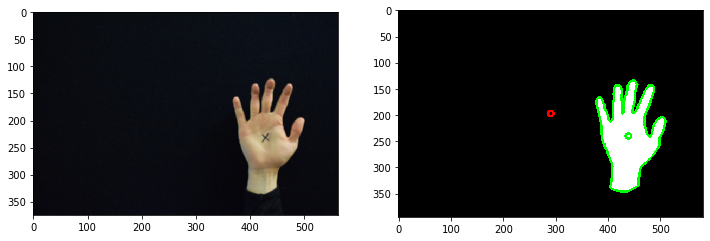

SEQUENCE:  3
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


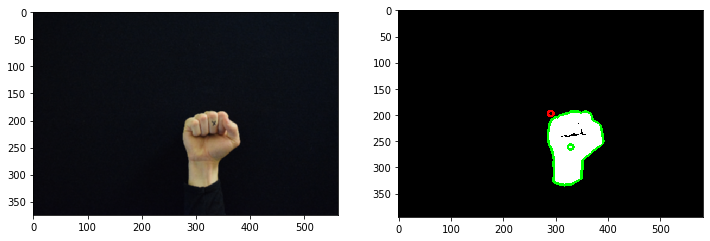

SEQUENCE:  3
Actual:  ['tl', 's']
Predicted:  ['tl', 's']
CORRECT


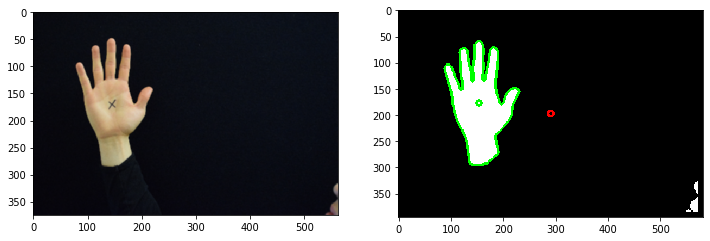

SEQUENCE:  4
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


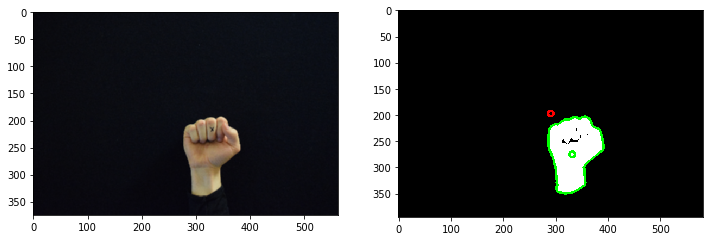

SEQUENCE:  4
Actual:  ['br', 's']
Predicted:  ['br', 's']
CORRECT


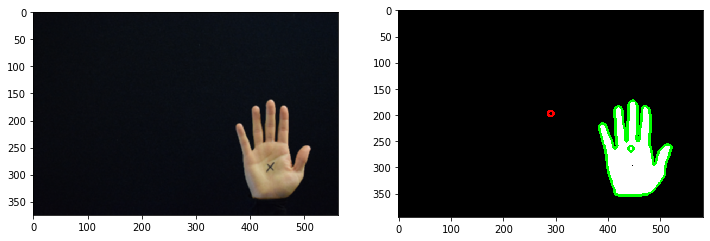

SEQUENCE:  5
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


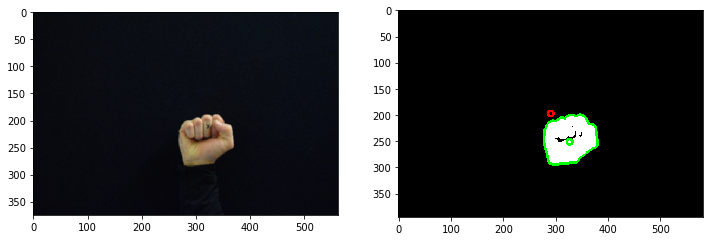

SEQUENCE:  5
Actual:  ['bl', 's']
Predicted:  ['bl', 's']
CORRECT


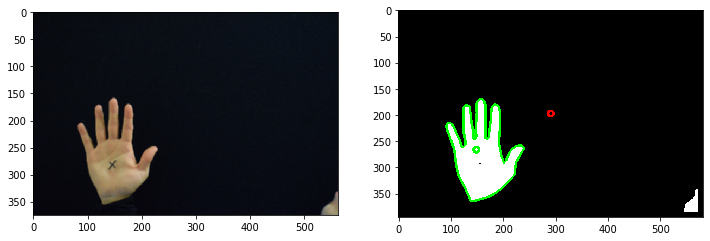

SEQUENCE:  6
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


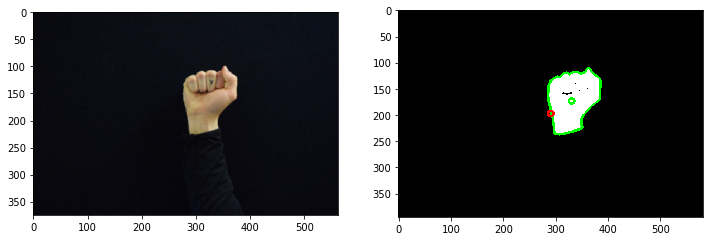

SEQUENCE:  6
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


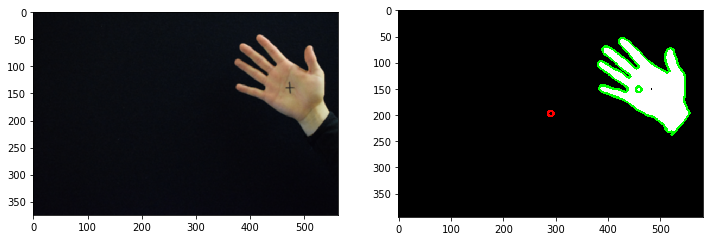

SEQUENCE:  7
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


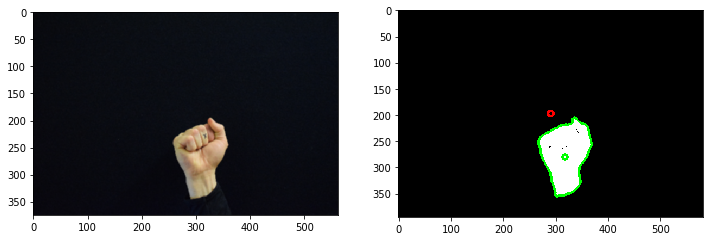

SEQUENCE:  7
Actual:  ['br', 's']
Predicted:  ['br', 's']
CORRECT


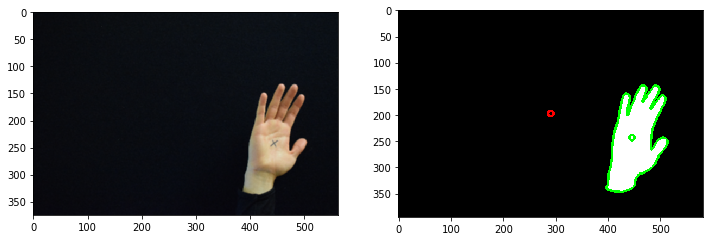

SEQUENCE:  8
Actual:  ['c', 'f']
Predicted:  ['c', 's']
INCORRECT


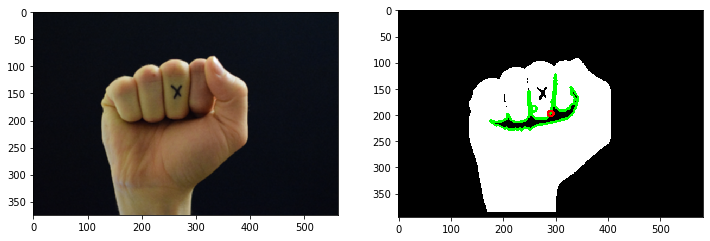

SEQUENCE:  8
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


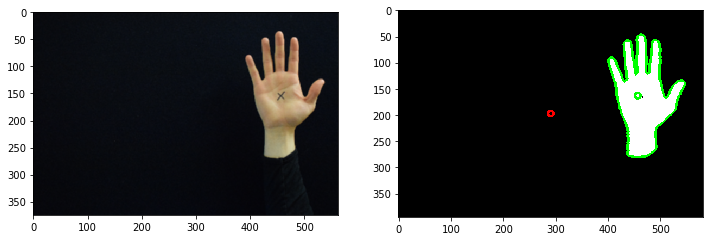

SEQUENCE:  9
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


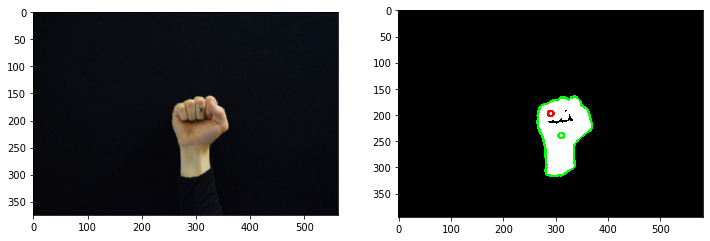

SEQUENCE:  9
Actual:  ['tr', 's']
Predicted:  ['tr', 's']
CORRECT


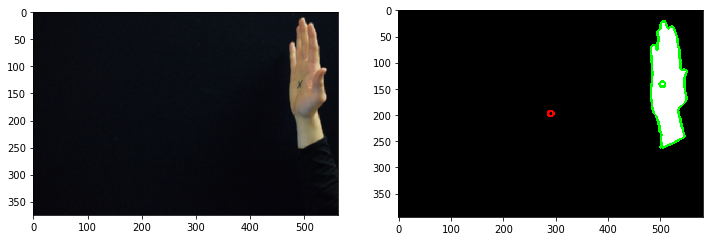

SEQUENCE:  10
Actual:  ['c', 'x']
Predicted:  ['c', 'f']
INCORRECT


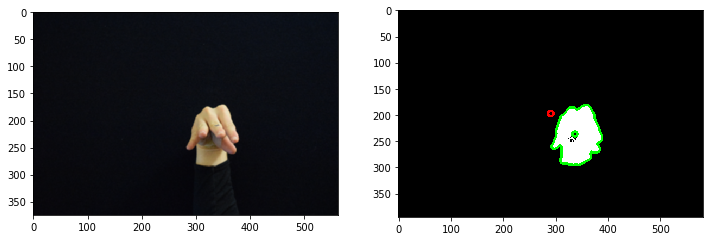

SEQUENCE:  10
Actual:  ['tr', 's']
Predicted:  ['tl', 'f']
INCORRECT


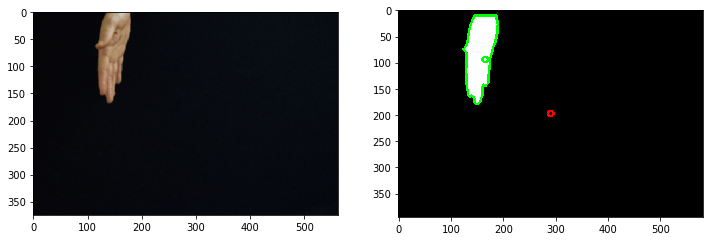

SEQUENCE:  11
Actual:  ['c', 'f']
Predicted:  ['c', 'f']
CORRECT


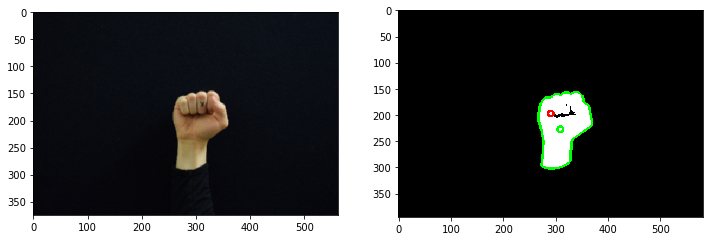

SEQUENCE:  11
Actual:  ['tl', 'f']
Predicted:  ['tl', 's']
INCORRECT


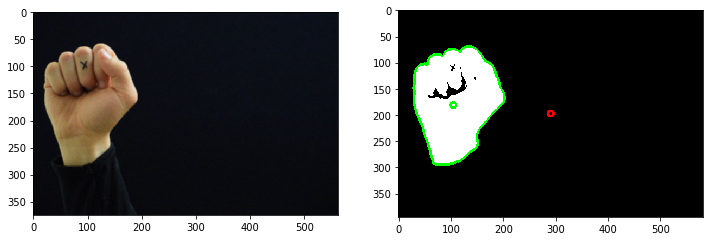

[['c', 'f'],
 ['tr', 's'],
 ['c', 'f'],
 ['tl', 's'],
 ['c', 'f'],
 ['br', 's'],
 ['c', 'f'],
 ['tl', 's'],
 ['c', 'f'],
 ['br', 's'],
 ['c', 'f'],
 ['bl', 's'],
 ['c', 'f'],
 ['tr', 's'],
 ['c', 'f'],
 ['br', 's'],
 ['c', 's'],
 ['tr', 's'],
 ['c', 'f'],
 ['tr', 's'],
 ['c', 'f'],
 ['tl', 'f'],
 ['c', 'f'],
 ['tl', 's']]

In [142]:
%cd /content/drive/My\ Drive/Interfaces/HW1/images/friend

analyze_sequence(friend_seq)



##1.4 Creativity Step - User Study

In this step, I briefly described the system to my friend and marked his hand with a black 'x'. 

Although lighting and camera settings remained constant, his skin tone, hand size, and understanding of the system varied from mine. Although I told my friend what the correct sequence was, namely, a closed fist in the center of the screen followed by a splayed palm in the corner, I did not tell him how my system actually detects hand position and location. 

This resulted in some variety in the ways he formed a fist or a splayed palm. Notably, unlike me, he didn't keep his hands a consistent distance from the camera at all times. Sometimes he brought his closed fist closer to the screen; although the fist was closed, the perimeter was large enough to be registered as a splayed palm. 

Also, he was not as concerned with orientation as I was, because he did not realize that, with the splayed palm for example, the gaps between fingers must be seen to calculate perimeter.

In the above sequences, eight were predicted accurately and four innacurately. Of the four false predictions, two were false positives and two were false negatives. 

*False Negatives*

In sequence 8, my friend placed his centered fist very close to the camera. Because the light source in the room was overhead, his knuckles cast a shadow on the palm of his hand, creating a dark space in the center. This was detected as the most "significant" contour because it had the greatest number of points – in other words, it was the most complex. Thus, even though it didn't have the largest perimeter, its complexity made it stand out to my system as the contour to pay attention to. However, the contour was still large enough to be detected as a splayed hand, resulting in a false negative. 

In sequence 9, once again, the orientation of the hand made the spaces between the fingers disappear, resulting in a smaller perimeter. This resulted in a fist being detected rather than a splayed hand. 

*False Positives*

In sequence 10, my friend made a hand shape that was not a fist, but the system detected it as a fist. Again, this is because 3D information is lost in this 2D analysis of the scene. The protrusion of his fingers towards the camera does not affect the perimeter of the skin area.

Finally, during sequence 11, I explained to my friend that a fist is differentiated from a splayed hand by perimeter, so he helped me create another false positive. In this case, two fists are seen consecutively but the second is registered as a splayed hand due to its proximity to the camera (and thus greater perimeter). 

Overall, knowledge of the domain and the system's inner workings definitely seem to affect the accuracy of a system. Having a participant who is unaware of the inner workings is useful because it brings about more edge cases and eventually results in a more flexible system.